In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [9]:
# Tickers & date range
# (If you change tickers or dates, just re-run this cell.)
tickers = ['TSLA', 'BND', 'SPY']
start_date = "2015-07-01"
end_date = "2025-07-31"

# Robust download with basic validation
import time
max_retries = 3
data = {}
failed = []
for t in tickers:
    for attempt in range(1, max_retries + 1):
        try:
            df = yf.download(t, start=start_date, end=end_date, progress=False, auto_adjust=False, threads=True)
            if df is None or df.empty:
                print(f"Attempt {attempt}: {t} returned empty data.")
            elif 'Close' not in df.columns:
                print(f"Attempt {attempt}: {t} missing 'Close' column. Columns: {list(df.columns)}")
            else:
                data[t] = df
                break
        except Exception as e:
            print(f"Attempt {attempt}: error downloading {t}: {e}")
        time.sleep(0.5)
    if t not in data:
        failed.append(t)

if failed:
    print(f"Skipped tickers (no usable data): {failed}")

if not data:
    raise ValueError("No data downloaded successfully. Check tickers, dates, or network connectivity.")

# Build Close price DataFrame only from successful tickers.
# Avoid Series.rename (was causing TypeError); assign column names explicitly.
series_list = []
col_names = []
for t, df in data.items():
    s = df['Close'].copy()
    series_list.append(s)
    col_names.append(t)

adj_close = pd.concat(series_list, axis=1)
adj_close.columns = col_names
adj_close = adj_close.sort_index()

# Replace original tickers list with successfully downloaded ones so later cells adapt
tickers = col_names
print(f"Downloaded tickers: {tickers}")
print("adj_close shape:", adj_close.shape)
print(adj_close.head())

Downloaded tickers: ['TSLA', 'BND', 'SPY']
adj_close shape: (2535, 3)
                 TSLA        BND         SPY
Date                                        
2015-07-01  17.943333  80.900002  207.500000
2015-07-02  18.667999  81.099998  207.309998
2015-07-06  18.648001  81.379997  206.720001
2015-07-07  17.858667  81.459999  208.020004
2015-07-08  16.997334  81.690002  204.529999


In [10]:
print("\nBasic Statistics:")
print(adj_close.describe())

# Missing values check
print("\nMissing Values Count:")
print(adj_close.isnull().sum())

# Fill missing values (Forward Fill)
adj_close = adj_close.fillna(method='ffill')

# Daily percentage returns
daily_returns = adj_close.pct_change().dropna()


Basic Statistics:
              TSLA          BND          SPY
count  2535.000000  2535.000000  2535.000000
mean    131.963002    79.644994   355.426505
std     120.914904     5.370225   118.237179
min       9.578000    68.040001   182.860001
25%      18.967667    73.800003   258.535004
50%      94.571335    81.029999   328.730011
75%     236.761665    83.945000   438.084991
max     479.859985    89.480003   637.099976

Missing Values Count:
TSLA    0
BND     0
SPY     0
dtype: int64


C:\Users\hp\AppData\Local\Temp\ipykernel_15724\4071186059.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adj_close = adj_close.fillna(method='ffill')


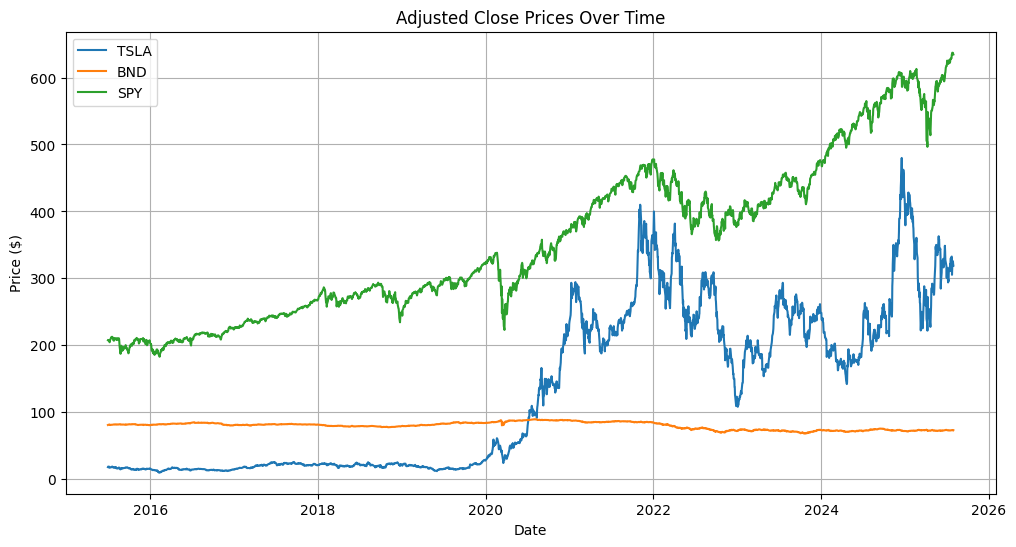

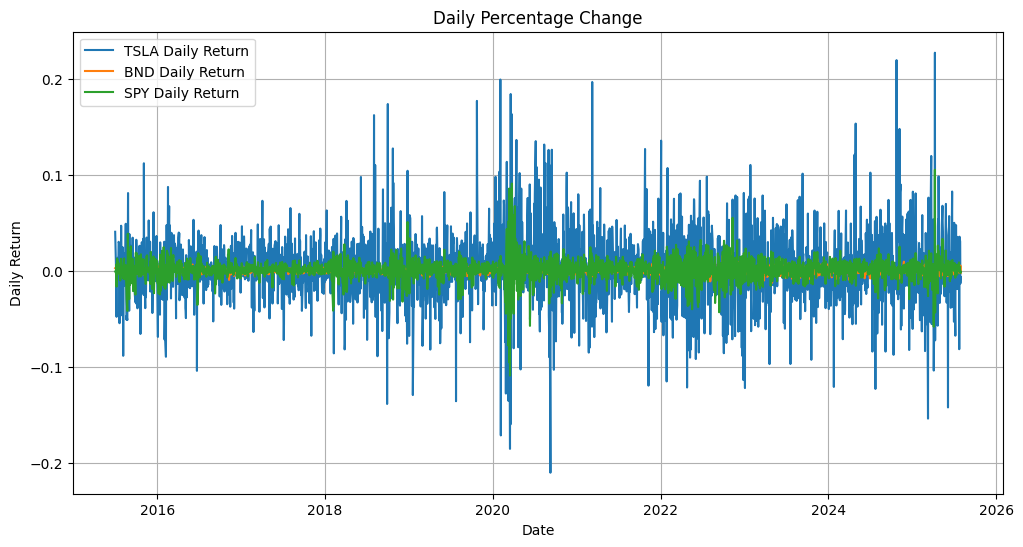

In [11]:
# Adjusted close prices over time
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(adj_close.index, adj_close[ticker], label=ticker)
plt.title("Adjusted Close Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

# Daily returns
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(daily_returns.index, daily_returns[ticker], label=f"{ticker} Daily Return")
plt.title("Daily Percentage Change")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.show()


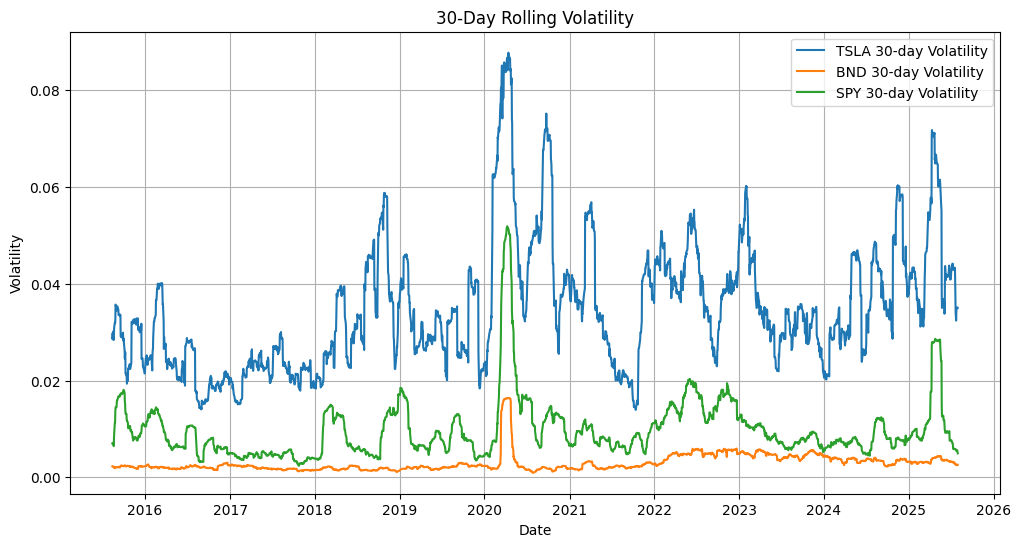

In [12]:
rolling_volatility = daily_returns.rolling(window=30).std()

plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(rolling_volatility.index, rolling_volatility[ticker], label=f"{ticker} 30-day Volatility")
plt.title("30-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
def adf_test(series, title=''):
    print(f"\nAugmented Dickey-Fuller Test: {title}")
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '# Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out)
    if result[1] < 0.05:
        print("✅ The series is stationary.")
    else:
        print("❌ The series is NOT stationary.")

for ticker in tickers:
    adf_test(adj_close[ticker], title=ticker)


Augmented Dickey-Fuller Test: TSLA
ADF Statistic                    -1.418872
p-value                           0.573196
# Lags Used                      27.000000
Number of Observations Used    2507.000000
Critical Value (1%)              -3.432961
Critical Value (5%)              -2.862694
Critical Value (10%)             -2.567384
dtype: float64
❌ The series is NOT stationary.

Augmented Dickey-Fuller Test: BND
ADF Statistic                    -0.794302
p-value                           0.820790
# Lags Used                      13.000000
Number of Observations Used    2521.000000
Critical Value (1%)              -3.432947
Critical Value (5%)              -2.862687
Critical Value (10%)             -2.567381
dtype: float64
❌ The series is NOT stationary.

Augmented Dickey-Fuller Test: SPY
ADF Statistic                     0.421327
p-value                           0.982275
# Lags Used                       9.000000
Number of Observations Used    2525.000000
Critical Value (1%)       

In [14]:
VaR_95 = daily_returns.quantile(0.05)
sharpe_ratios = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)

summary = pd.DataFrame({
    "VaR_95": VaR_95,
    "Sharpe Ratio": sharpe_ratios
})

print("\nRisk Metrics Summary:")
print(summary)


Risk Metrics Summary:
        VaR_95  Sharpe Ratio
TSLA -0.054663      0.778340
BND  -0.005166     -0.151999
SPY  -0.017392      0.698854
